# Machine Learning Spam Filter

In this project, I create a classifier to distinguish spam emails from normal ones. Specifically, I use supervised learning to classify each email as such. This notebook walks you through the whole process, from data processing to training a model. 

In the end, it attains 99.4% accuracy. 

---

# Initial Analysis


In [41]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

The dataset consists of email messages and their labels (0 for ham, 1 for spam). It contains 8348 labelled examples. In the end, I evaluate it on 1000 unlabelled examples. 

The `train` DataFrame contains labelled data that you I use to train my model. It contains three columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email
1. `email`: The text of the email.
1. `spam`: 1 if the email was spam, 0 if the email was ham (not spam).

The `evaluation` DataFrame contains another set of 1000 unlabelled examples. I predict the category for them, and then evaluate them afterwards.

In [42]:
original_training_data = pd.read_csv('data/train.csv')
evaluation = pd.read_csv('data/eval.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
evaluation['email'] = evaluation['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


## Train-Test Split

The training data I use is all the data  available for both training models and **testing** the models that we train.  We therefore need to split the training data into separate training and test datsets.

In [43]:
from sklearn.model_selection import train_test_split

[train, test] = train_test_split(original_training_data, test_size=0.1, random_state=42)

Let's take a look at two emails--one spam and one ham-- and see if we can get some differences between them and help us start thinking about features.

In [44]:
first_ham = list(train[train['id'] == 7657]['email'])[0]
first_spam = list(train[train['id'] == 5247]['email'])[0]

In [45]:
first_ham

'while i was playing with the past issues, it annoyed me that there was\n no easy way to make the log stop growing (i don\'t mean to truncate it,\n i mean to just freeze it for a while).\n \n the following patch adds a new button to the log window, which allows\n the log to be switched on/off (the button says "disable" when the\n log is enabled, and the button disables it, and "enable" when the log\n is frozen, and the button enables it again).\n \n kre\n \n --- main.tcl\twed aug 21 15:01:48 2002\n +++ /usr/local/lib/exmh-2.5/main.tcl\twed aug 28 17:36:59 2002\n @@ -385,6 +385,9 @@\n  \texmhlogcreate\n  \twm withdraw $exmh(logtop)\n      }\n +    if {! $exmh(logwrite)} {\n +\treturn\n +    }\n      if [info exists exmh(log)] {\n  \tcatch {\n  #\t    $exmh(log) insert end " [bw_delta] "\n @@ -407,6 +410,9 @@\n      set exmh(logwindow) 1\n      exwin_toplevel .log "exmh log" log\n      set exmh(logtop) .log\n +    set exmh(logdisablebut) \\\n +\t[widget_addbut $exmh(logtop).but swap "dis

In [46]:
first_spam

'--===_secatt_000_1fuklemuttfusq\n content-type: text/plain; charset="us-ascii"\n content-transfer-encoding: quoted-printable\n \n aluko martin\n 23 victoriagarden city=2c\n lagos-nigeria=2e\n \n attn=2e\n \n \n we have an immediate business proposal that involves us$34=2c700=2c000\n which we will like to invest under your custody=2e please=2c do not\n hesitate\n to send me an email=2c so as to discuss with you the details of the\n transaction=2fthe\n terms and condition of sharing regarding the business=2e\n your urgent response will be highly appreciated and will swiftly\n bring us\n to the commencement of the transaction=2e we hope to conclude this\n transaction\n within 10-12 working days=2e do not forget to contact me on receipt of\n this\n mail=2e and please ensure to maintain absolute confidentiality with\n regard to\n this\n pending transaction=2e i urgently await your response=2e\n \n best regards=2c\n \n aluko martin=2e\n \n -- \n \n \n --===_secatt_000_1fuklemuttfusq\n conte

Clearly the formating is not so great. It's hard to even read these examples since we see metacharacters such as line breaks. We'll have to clean this and figure out how to handle these cases. 

Now looking at the subject of the emails, we can see some obvious differences that most would expect. One difference we can notice has to do with the topic of the conversation. A mundane conversation on mathematics is a ham one,  whereas one concerning a Nigerian prince's bank account (hah) is the other. Looking at the words, we get a hunch that money-related words may be an indication of spam. After all, spam emails are sent to make money in one way or another.


# Basic EDA

Now we need to identify some features that allow us to tell spam and ham emails apart. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


First I create a function called words_in_texts that takes in a list of words and a pandas Series of email texts. It outputs a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. 

In [47]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    matches_df = pd.DataFrame()
    row = 0
    for text in texts:
        matches_df[row] = pd.Series(([int(i in text) for i in words]))
        row += 1
    matches_array = matches_df.transpose().values
    return matches_array
  

#Test
words_in_texts(['hello', 'bye', 'world'], 
                                  pd.Series(['hello', 'hello world hello']))

array([[1, 0, 0],
       [1, 0, 1]])

Now, I can create a bar chart to get an idea of how certain words appear in ham or spam emails. 

In [48]:
def words_in_text_df(words, spam = None):
    """
    Param: WORDS takes in LIST of STRINGS you want to match
    Return: df with cols of each word to match. 1 means it is in text
    """
    if(spam == None):
        return pd.DataFrame(words_in_texts(words ,  original_training_data['email']), columns = words)
    if(spam == True):
        return pd.DataFrame(words_in_texts(words ,  original_training_data[original_training_data['spam'] == 1]['email']), columns = words)
    else:
        return pd.DataFrame(words_in_texts(words ,  original_training_data[original_training_data['spam'] == 0]['email']), columns = words)

In [49]:
# #sanity check
# words = ['body', 'business', 'html', 'money', 'offer', 'please']
# matches = words_in_text_df(words, False)
# assert len(matches) + len(words_in_text_df(words, True)) == len(words_in_text_df(words))


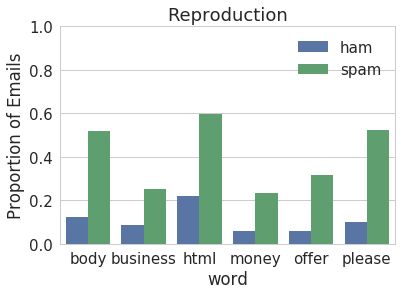

In [50]:
words = ['body', 'business', 'html', 'money', 'offer', 'please']
spam_df = words_in_text_df(words, spam=True)
spam_prop = (spam_df.sum() / len(spam_df)).to_frame()
spam_prop['spam'] = 'spam'
spam_prop.reset_index(inplace=True)
spam_prop.rename(columns = {'index':'word', 0:'prop'}, inplace = True)


ham_df = words_in_text_df(words, spam=False)
ham_prop = (ham_df.sum() / len(ham_df)).to_frame()
ham_prop['spam'] = 'ham'
ham_prop.reset_index(inplace=True)
ham_prop.rename(columns = {'index':'word', 0:'prop'}, inplace = True)

concat_df = pd.concat([ham_prop, spam_prop])
# total_df = ham_prop.merge(spam_prop, on='word')

fig, ax = plt.subplots()
sns.barplot(x = concat_df['word'], y = concat_df['prop'], hue = concat_df['spam'])
ax.set_ylabel('Proportion of Emails')
plt.ylim((0, 1))
ax.legend()
plt.title('Reproduction')

Let's do another--why not

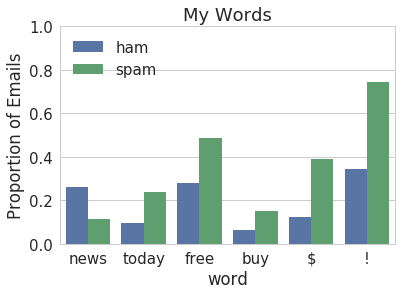

In [51]:
words = ['news', 'today', 'free', 'buy', '$', '!']
spam_df = words_in_text_df(words, spam=True)
spam_prop = (spam_df.sum() / len(spam_df)).to_frame()
spam_prop['spam'] = 'spam'
spam_prop.reset_index(inplace=True)
spam_prop.rename(columns = {'index':'word', 0:'prop'}, inplace = True)


ham_df = words_in_text_df(words, spam=False)
ham_prop = (ham_df.sum() / len(ham_df)).to_frame()
ham_prop['spam'] = 'ham'
ham_prop.reset_index(inplace=True)
ham_prop.rename(columns = {'index':'word', 0:'prop'}, inplace = True)

concat_df = pd.concat([ham_prop, spam_prop])
# total_df = ham_prop.merge(spam_prop, on='word')

fig, ax = plt.subplots()
sns.barplot(x = concat_df['word'], y = concat_df['prop'], hue = concat_df['spam'])
ax.set_ylabel('Proportion of Emails')
plt.ylim((0, 1))
ax.legend()
plt.title('My Words')

When a feature is binary, it makes sense to compare the proportion of 1s in the two classes of email. Otherwise, if the feature can take on many values, it makes sense to compare the distribution under spam to the distribution under ham. So, we create a class conditional density plot to compare the distribution of a feature among all spam emails to the distribution of the same feature among all ham emails.

In [52]:
import re
word_pct = pd.read_csv('data/train.csv')
word_pct_spam = word_pct[word_pct.loc[:, 'spam'] == 1]

word_pct_ham = word_pct[word_pct.loc[:, 'spam'] == 0]

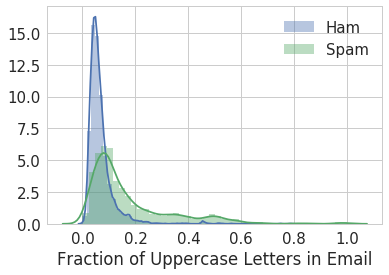

In [53]:
# Gets rid of bugy settingwithcopywarning; my assignments are ok
pd.options.mode.chained_assignment = None

word_pct_spam.loc[:, 'pct'] = word_pct_spam.loc[:, 'email'].str.findall('[A-Z]').str.len() / word_pct_spam.loc[:, 'email'].str.findall('[a-zA-Z]').str.len()

word_pct_ham.loc[:, 'pct'] = word_pct_ham.loc[:, 'email'].str.findall('[A-Z]').str.len() / word_pct_ham.loc[:, 'email'].str.findall('[a-zA-Z]').str.len()



sns.distplot(word_pct_ham['pct'])
sns.distplot(word_pct_spam['pct'])
plt.xlabel('Fraction of Uppercase Letters in Email')
plt.legend(['Ham', 'Spam'])

For demonstration purposes (before I use a nice SK-learn feature that does a lot more), I will hand-code a 

# Feature Engineering

As you have probably noticed, we want to take the text of an email and predict whether the text is ham or spam. This is a classification problem, so we can use logistic regression to make a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $\Phi$ (pronounced phi as in wifi) and corresponding binary labels $Y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $\Phi$ is derived from one email example. Each column of $\Phi$  is one feature.

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

Before I use some more complex and nebulous SK-learn features and more complicated matrix work, I will hand-code a feature for our model. I do this to demonstrate the basic premise of feature engineering here. 

Specifically, I use 5 words that are probably useful to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `Phi_train` and `Y_train`.

`Phi_train` is a matrix of 0s and 1s created by using the `words_in_texts` function on all the emails in the training set.

`Y_train` is a vector of the correct labels for each email in the training set.

In [54]:
useful_words = ['drug', 'bank', 'prescription', 'memo', 'private']

Phi_train = words_in_texts(useful_words, train['email'])
Y_train = train['spam']

Phi_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), 7657    0
 6911    0
 6074    0
 4376    0
 5766    0
 Name: spam, dtype: int64)

In [55]:
# sanity checks
assert np.all(np.unique(Phi_train) == np.array([0, 1]))
assert np.all(np.unique(Y_train) == np.array([0, 1]))
assert Phi_train.shape[0] == Y_train.shape[0]
assert Phi_train.shape[1] == len(useful_words)

Now we have matrices we can give to scikit-learn! Using the Logistic Regression classifier, I train a logistic regression model using `Phi_train` and `Y_train`. Then, I output the accuracy of the model (on the training data) in the cell below. This will probably not be so great. 

In [56]:
from sklearn import linear_model as lm

model1 = lm.LogisticRegression()
model1.fit(Phi_train, Y_train)

training_accuracy = model1.score(Phi_train, Y_train)

training_accuracy

0.75762012511646482

Hmmm seems to be pretty good at first glance... but think about it longer and you realize why. First, we are evaluating on the training set, which may lead to a misleading accuracy measure, especially if we used the training set to identify discriminative features. 

Presumably, our classifier will be used for filtering, i.e. preventing messages labelled `spam` from reaching someone's inbox. Since we are trying  There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabelled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham. 

Keeping this in mind, let's consider a few quiestions:

- Suppose we have a classifier that just predicts 0 (ham) for every email. How many false positives are there? How many false negatives are there?

    *Intuitively, there will be no false positives (aka a ham email getting flagged as spam). However, there will be as many false negatives as there are spam emails in the dataset, as all spam emails are mislabelled as ham. In this case, that count is 1918 false negatives.*
    
    
- Suppose we have a classifier that just predicts 0 (ham) for every email. What is its accuracy on the training set? What is its recall on the training set?

    *Again, using our intuition, the accuracy is just the proportion of ham emails in the set. Doing this, we get acc = .745. We can also use our intution to calculate recall. Recall is just 0, since there are 0 true positives and dividing 0 by anything is just 0.*


- What are the precision, recall, and false-alarm rate of the logistic regression classifier above?

In [57]:
y_pred = 0
y_test = train['spam']
y_predict = model1.predict(Phi_train)

# provide training accuracy & recall, respectively,
# for logistic regression classifier from question 5
logistic_predictor_precision = sum((y_predict == y_test) & (y_predict == False)) / (sum((y_predict == y_test) & (y_predict == False)) + sum((y_predict != y_test) & (y_predict == True)))
logistic_predictor_recall = sum((y_predict == y_test) & y_predict == True) / (sum((y_predict == y_test) & (y_predict == True)) + sum((y_predict != y_test) & (y_predict == False)))
logistic_predictor_far = sum((y_predict != y_test) & (y_predict == True)) / (sum((y_predict != y_test) & (y_predict == True)) + sum((y_predict == y_test) & (y_predict == False)))

print("precision: " + str(logistic_predictor_precision))
print("recall: " + str(logistic_predictor_recall))
print("false alarm rate: " + str(logistic_predictor_far))

precision: 0.978194816800715
recall: 0.11418143899895725
false alarm rate: 0.021805183199285077


## More Feature Engineering

Clearly, our model needs many better features to be used as a respectable spam filter. Below we do just that. I will go less into theory, since I laid out some basic examples above!

In [58]:
def clean_email_text(dataframe):
    """
    Takes in a DF with an 'email' column
    returns a cleaned email column
    """
    dataframe['email'] = dataframe['email'].str.lower() #make everything lower case
    dataframe['email'] = dataframe['email'].str.replace(r'<[^>]+>', '') #remove HTML
    dataframe['email'] = dataframe['email'].str.replace(r'^\s+|\s+?$', '') #make lower case
    dataframe['email'] = dataframe['email'].str.replace(r'[^\w\d\s]', ' ') #remove punctuation
    dataframe['email'] = dataframe['email'].str.replace(r'\s+', ' ') #replace multiple spaces
    return dataframe

In [59]:
def punctuation_count(dataframe):
    """
    Normalized count number of ! or ? in an email
    Takes in DF (assumes 'email' column). Must be UNFORMATED!
    """
    dataframe.loc[:, 'norm_excl_count'] = dataframe.loc[:, 'email'].str.count(r'[!]') / (dataframe.loc[:, 'email'].str.len()+1)
    dataframe.loc[:, 'norm_quest_count'] = dataframe.loc[:, 'email'].str.count(r'[?]') / (dataframe.loc[:, 'email'].str.len()+1)
    return dataframe

In [60]:
def email_length(dataframe):
    # Raw length of DF
    dataframe.loc[:, 'len'] = copy.loc[:, 'email'].str.len()
    return dataframe

Below I create a nice feature using a [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (term frequency–inverse document frequency) vectorizer. SK-Learn has a great method that does this. It is a numerical statistic that reflects how important a word is to a document in a collection (in this case, email text). The tf-idf value increases proportionally to the number of times a word appears in an email, and is offset by the frequency of the word in the entire email collection, which helps to adjust for the fact that some words appear more frequently in general.

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import scipy as scipy
from scipy.sparse import hstack

def tfidf_processor(dataframe):
    """
    this method employs tf-idf (Term Frequency times Inverse Document Frequency). It avoids potential
    discrepancies that arise from a simple bag of words representation.
    Takes in a Dataframe, returns X data in a SPARSE matrix to save memory, which
    works since most values are 0.
    @Source SK-Learn http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    """
    # Converts text to a sparse matrix of token counts
    count_vect = CountVectorizer()
    X_train_vectorized = count_vect.fit_transform(dataframe['email'])

    # Now employ a tdidf transorm to the matrix using SKLearn documentation
    # Fit the transformer to the data, then then actually transform the data to sparse matrix
    tfidf_transformer = TfidfTransformer(use_idf=True).fit(X_train_vectorized)
    X_train_tfidf = tfidf_transformer.transform(X_train_vectorized)

    return count_vect, tfidf_transformer, X_train_tfidf

Create an SK-Learn pipeline. A cool aside if you're not familiar with this topic. Since there are millions of word combinations, we need to use a sparse matrix. It helps keep space use efficient. In ML, its quite useful with large swathes of data. You'll see some lines of code below that handel these matrix parts. 

In [62]:
def pipeline(data):
    """
    Takes in a DataFrame, applies transformations in pipeline.
    Assumes format of data as having 'email' and 'subject' column
    Returns: X_train, y_train, a fitted count_vecorizer method, a fitted tfidfTransformer (NOTE: These last 2
    are key latter so you can use it for the test/eval data! If you call a new vect_count or tfidf method, your sparse
    matrices are the incorrect size because the method evaluates the text differently, creating different combinations!). 
    also, X_train is a SPARSE matrix!
    """
    # clean the email text column for vectorization
    cleaned_emails = clean_email_text(data)
    
    # Here I use SK-Learn's CountVectorizer method, which
    # Converts text to a ~sparse~ matrix of token counts
    count_vectorizer = CountVectorizer()
    X_train_email_counts = count_vectorizer.fit_transform(cleaned_emails['email'])
    
    # Now we employ a tdidf transorm to the matrix using SKLearn's tf-dif 
    # (Term Frequency times Inverse Document Frequency). It avoids potential
    # bias that arises from the simple bag of words approach. So, below we 
    # Fit the transformer to the data, then then transform ir to a sparse matrix
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_email_counts)
    
    # Now we take the uncleaned data and create a feature that has proportion of
    # exclamation points and question marks. NOTE this is not in a sparse matrix
    # format so we need to convert it to that. We CANNOT conver a sparse matrix
    # to a regular DF because that may either crash your browser or melt your computer.
    X_punct_props =  punctuation_count(data)[['norm_excl_count', 'norm_quest_count']]
    X_punct_props_sparse = scipy.sparse.csr_matrix(X_punct_props.values)
    
    # Now we need to put these two sparse matrices together via scipy
    X = hstack((X_punct_props_sparse, X_train_tfidf))
    
    # What the training data should be
    y = data['spam']
    
    return X, y, count_vectorizer, tfidf_transformer

Now let's train our model!

In [63]:
[train, test] = train_test_split(original_training_data, test_size=0.1, random_state=42)

X_train, y_train, count_vectorizer, tfidf_transformer = pipeline(train)

Here's our model

In [64]:
from sklearn import linear_model as lm
final_model = lm.LogisticRegressionCV()
final_model.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [65]:
# Process Test/Evaluative Data
def process_data(data, count_vectorizer, tfidf_transformer):
    
    cleaned_emails = clean_email_text(data)
    X_counts = count_vectorizer.transform(cleaned_emails['email'])
    X_tfidf = tfidf_transformer.transform(X_counts)

    punct = punctuation_count(data)[['norm_excl_count', 'norm_quest_count']]
    punct_sparse = scipy.sparse.csr_matrix(punct.values)
    X = hstack((punct_sparse, X_tfidf))
    
    return X
    
X_test = process_data(test, count_vectorizer, tfidf_transformer)
    
predicted = final_model.predict(X_test)

# So how did we do wrt to the test data?
np.mean(predicted == test['spam'])  

0.99281437125748506

99.2 accuracy on the test data. Not shabby at all! I use Kaggle to ultimately evaluate my performance on the rest of the data. Here's the code for that below. 

In [66]:
eval_data = pd.read_csv('data/eval.csv')

X_eval = process_data(eval_data, count_vectorizer, tfidf_transformer)

eval_predicted = final_model.predict(X_eval)


# submission_df = pd.DataFrame({
#     "Id": evaluation['id'], 
#     "Class": evaluation_predictions,
# }, columns=['Id', 'Class'])
# timestamp = datetime.isoformat(datetime.now()).split(".")[0]
# submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

# print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))

Just to be sure these results are worthwhile, I create a Precession-Recall Curve. Before checking the actual graph, you may have an idea of what it will look like... a flat line at 1 since this model is pretty good!

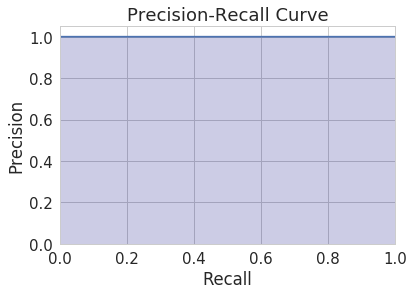

In [67]:
from sklearn.metrics import precision_recall_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

probs = final_model.predict_proba(X_train)
fpr, tpr, _ = precision_recall_curve(y_train, probs[:,1]) 
plt.plot(tpr, fpr, color='b')
plt.fill_between(tpr, fpr, step='post', alpha=0.2, color='navy')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
# The below plot makes sense since I have .99 accuracy.